In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import torch
import intel_extension_for_pytorch as ipex
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.splitter import ExpandingWindowSplitter
torch.xpu.is_available()

/home/sdp/.conda/envs/ag/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


True

Public dataset from Ashrae Great Energy Predictor (metadata, weather, meters).
Import cleaned electricity meters ("electricity_cleaned.csv")
https://github.com/buds-lab/building-data-genome-project-2/tree/master/data/meters/cleaned

In [2]:
df = pd.read_csv("electricity_cleaned.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"],format="%m/%d/%y %H:%M")
df.set_index('timestamp')
df.tail()

,timestamp,Panther_parking_Lorriane,Panther_lodging_Cora,Panther_office_Hannah,Panther_lodging_Hattie,Panther_education_Teofila,Panther_education_Jerome,Panther_retail_Felix,Panther_parking_Asia,Panther_education_Misty,...,Cockatoo_public_Caleb,Cockatoo_education_Tyler,Cockatoo_public_Shad,Mouse_health_Buddy,Mouse_health_Modesto,Mouse_lodging_Vicente,Mouse_health_Justin,Mouse_health_Ileana,Mouse_health_Estela,Mouse_science_Micheal
17539,2017-12-31 19:00:00,15.4830,135.2261,3.4357,79.1353,105.6374,465.0898,67.0199,35.7069,16.3231,...,96.925,704.950,111.350,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17540,2017-12-31 20:00:00,12.7224,135.9262,3.4087,81.6958,107.7348,463.6895,56.6869,35.7069,16.0831,...,97.550,695.700,115.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17541,2017-12-31 21:00:00,11.2822,135.1761,3.3546,82.8160,106.1295,461.2890,55.0576,35.5068,16.1631,...,93.825,687.325,111.650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17542,2017-12-31 22:00:00,16.9233,137.6266,3.2876,82.3359,109.6282,460.5889,49.6776,35.7069,14.8829,...,94.150,674.275,111.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17543,2017-12-31 23:00:00,11.8223,136.1263,3.3686,82.4959,103.7540,462.0892,42.6952,35.6069,16.0031,...,96.325,677.400,113.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Autogluon and GluonTS expect stacked timeseries in time, id, and target

In [3]:
col = df.iloc[0:1,1:1578]
dfm = pd.melt(df, id_vars='timestamp', value_vars=col.columns, var_name='item_id', value_name='target')
dfm.tail()

,timestamp,item_id,target
27666883,2017-12-31 19:00:00,Mouse_health_Estela,NaN
27666884,2017-12-31 20:00:00,Mouse_health_Estela,NaN
27666885,2017-12-31 21:00:00,Mouse_health_Estela,NaN
27666886,2017-12-31 22:00:00,Mouse_health_Estela,NaN
27666887,2017-12-31 23:00:00,Mouse_health_Estela,NaN


In [4]:
prediction_length = 24
context_length = 11000
data = TimeSeriesDataFrame(dfm) 
df_regular = data.convert_frequency(freq="h")
train_data, test_data = df_regular.train_test_split(prediction_length=prediction_length,end_index=context_length)
test_data.tail()
train_data.tail()

target
item_id             timestamp                  
Mouse_health_Estela 2017-04-02 03:00:00   300.0
                    2017-04-02 04:00:00   295.0
                    2017-04-02 05:00:00   295.0
                    2017-04-02 06:00:00   293.0
                    2017-04-02 07:00:00   282.0

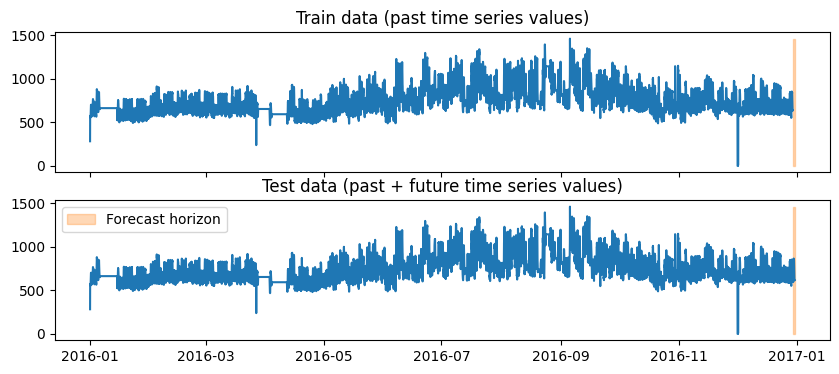

In [54]:
item_id = "Mouse_health_Justin"
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[10, 4], sharex=True)
train_ts = train_data.loc[item_id]
test_ts = test_data.loc[item_id]
ax1.set_title("Train data (past time series values)")
ax1.plot(train_ts)
ax2.set_title("Test data (past + future time series values)")
ax2.plot(test_ts)
for ax in (ax1, ax2):
    ax.fill_between(np.array([train_ts.index[-1], test_ts.index[-1]]), test_ts.min(), test_ts.max(), color="C1", alpha=0.3, label="Forecast horizon")
plt.legend()
plt.show()

Testing different context lengths and resulting sensitivity on prediction.  Note, device is being passed to model and XPU is being used (verified with xpu-smi dump -m 2,18 -i 2) 

In [5]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    freq="h",
    path="MWE-context-tuning",
    target="target",
    eval_metric="MASE",
    cache_predictions=False
)

predictor.fit(
    train_data,
    time_limit=1200,
    hyperparameters={
    "ChronosModel": [
        {"model_path": "amazon/chronos-t5-mini","device": 'xpu',"context_length": 500},
        {"model_path": "amazon/chronos-t5-mini","device": 'xpu',"context_length": 400},
        {"model_path": "amazon/chronos-t5-mini","device": 'xpu',"context_length": 300},
        {"model_path": "amazon/chronos-t5-mini","device": 'xpu',"context_length": 200},
        {"model_path": "amazon/chronos-t5-mini","device": 'xpu',"context_length": 100},
        {"model_path": "amazon/chronos-t5-mini","device": 'xpu',"context_length": 50},
    ],
    }
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to 'MWE-context-tuning'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #80-Ubuntu SMP Mon May 15 15:18:26 UTC 2023
CPU Count:          192
GPU Count:          0
Memory Avail:       991.03 GB / 1007.56 GB (98.4%)
Disk Space Avail:   779.41 GB / 866.44 GB (90.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': {'ChronosModel': [{'context_length': 500,
                                       'device': 'xpu',
                                       'model_path': 'amazon/chronos-t5-mini'},
                                      {'context_length': 400,
                                       'device': 'xpu',
                                       'model_path': 'amazon/chronos-t5-mini'},
                                      {'conte

In [61]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.552549,-0.650246,132.144874,131.920679,8.012008,7
1,Chronos[amazon__chronos-t5-mini],-0.557598,-0.653915,55.919134,56.105154,9.249946,1
2,Chronos_2[amazon__chronos-t5-mini],-0.563369,-0.664173,47.777720,47.417193,9.412129,2
3,Chronos_3[amazon__chronos-t5-mini],-0.579368,-0.703429,39.180701,39.103448,9.202727,3
4,Chronos_4[amazon__chronos-t5-mini],-0.598067,-0.698053,28.434720,28.398332,9.241679,4
5,Chronos_5[amazon__chronos-t5-mini],-0.728694,-0.976051,18.388909,18.336174,9.269090,5
6,Chronos_6[amazon__chronos-t5-mini],-0.754497,-0.958500,17.650136,17.791780,9.237947,6


Now observe predictions and time for predicicting the time series set

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


CPU times: user 4min 38s, sys: 10.8 s, total: 4min 49s
Wall time: 2min 16s


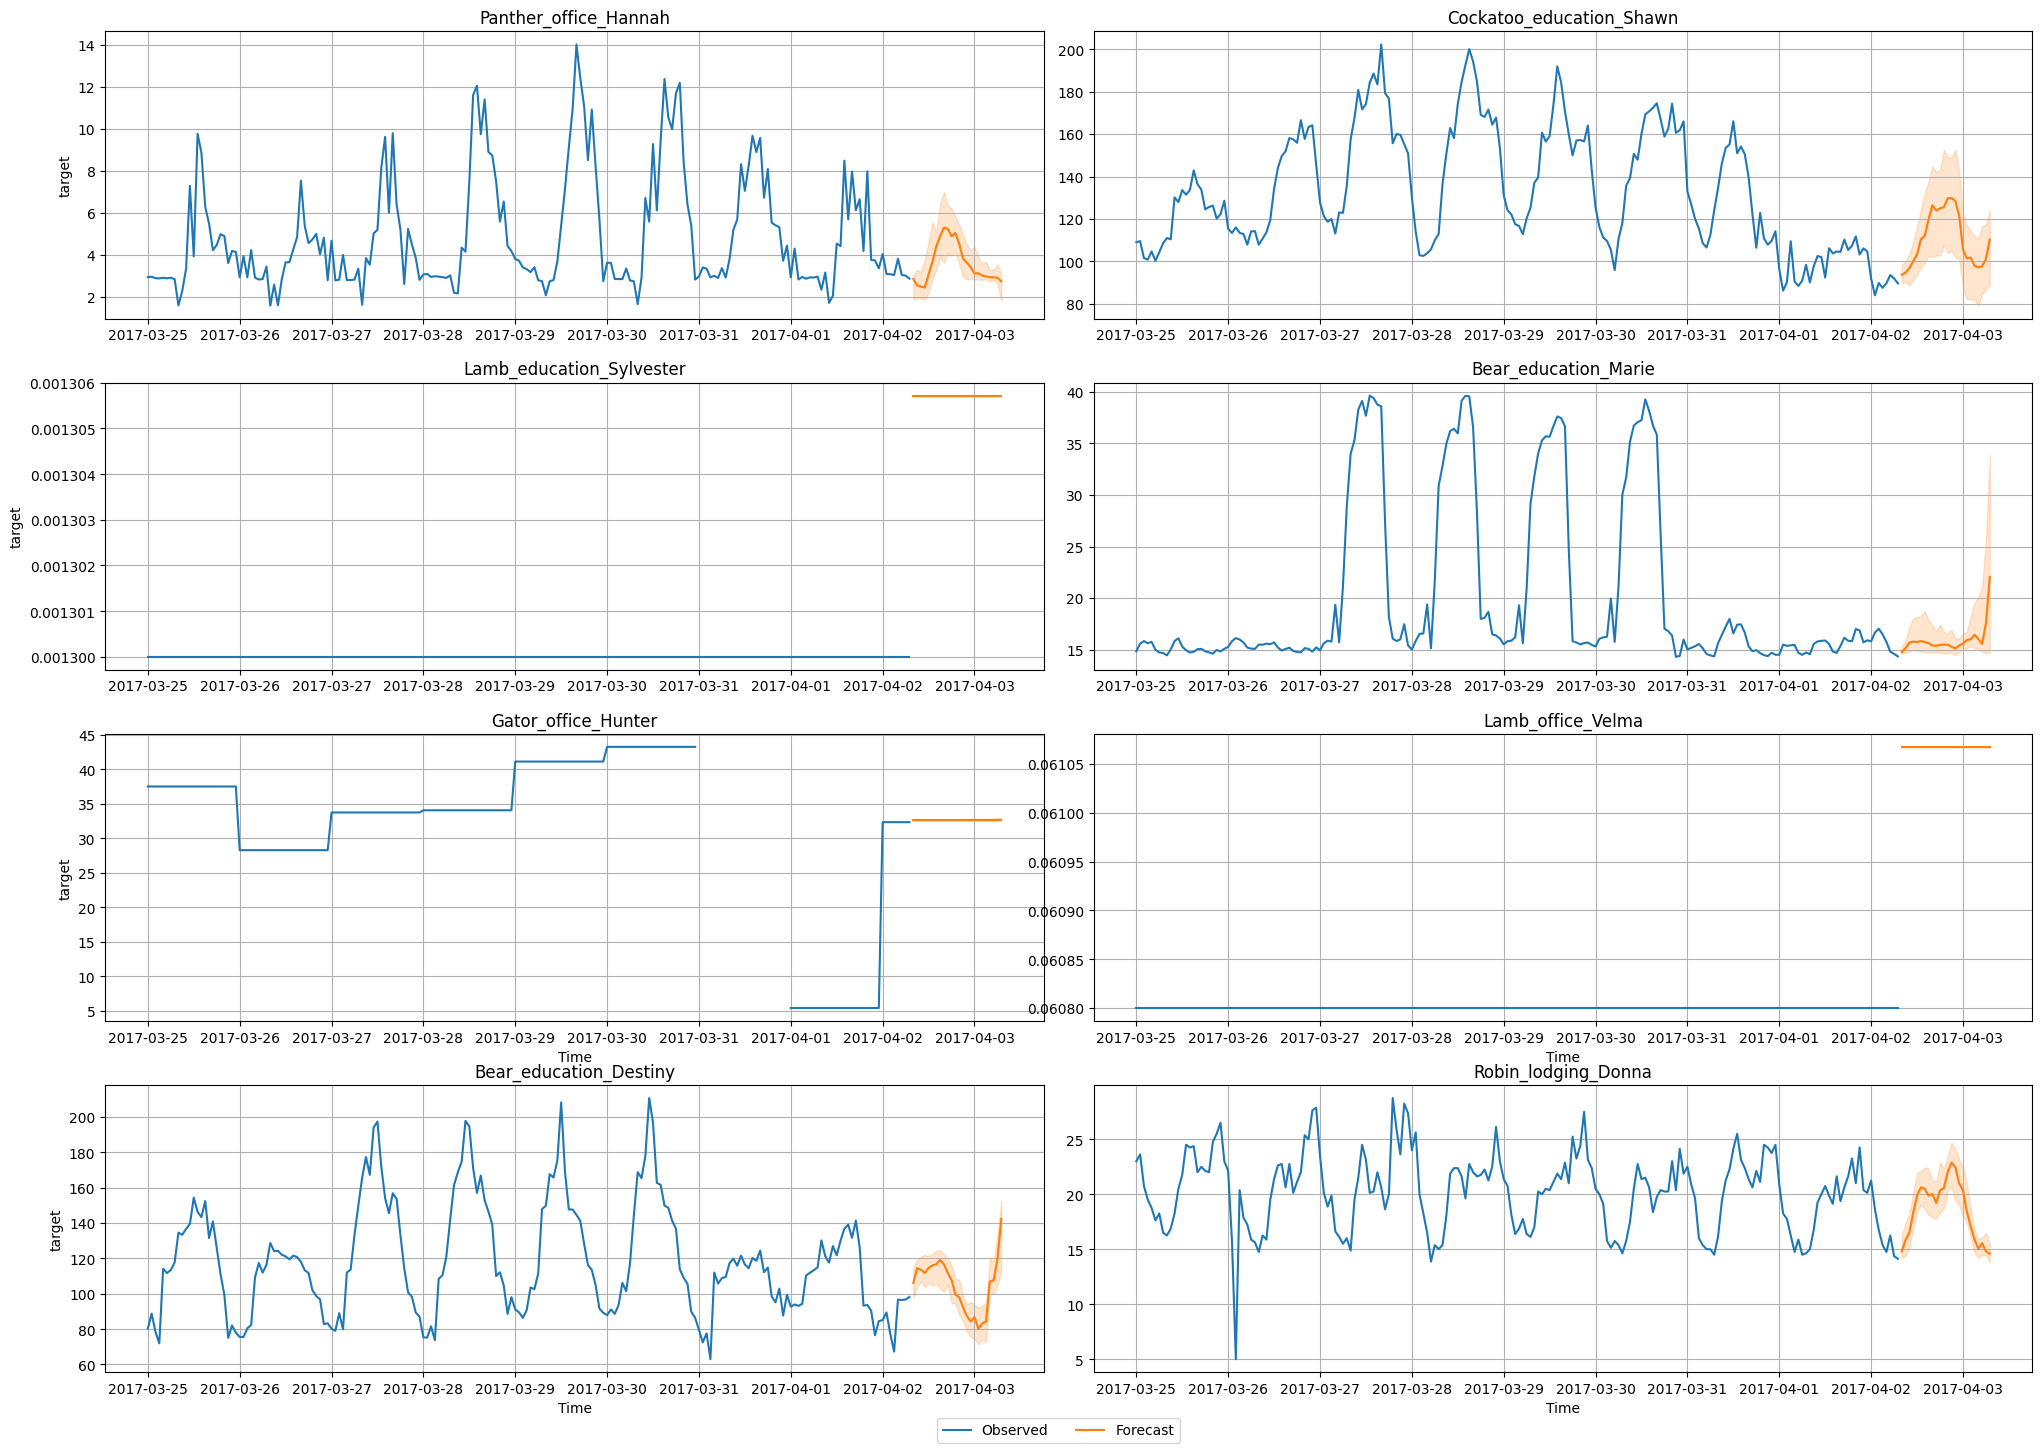

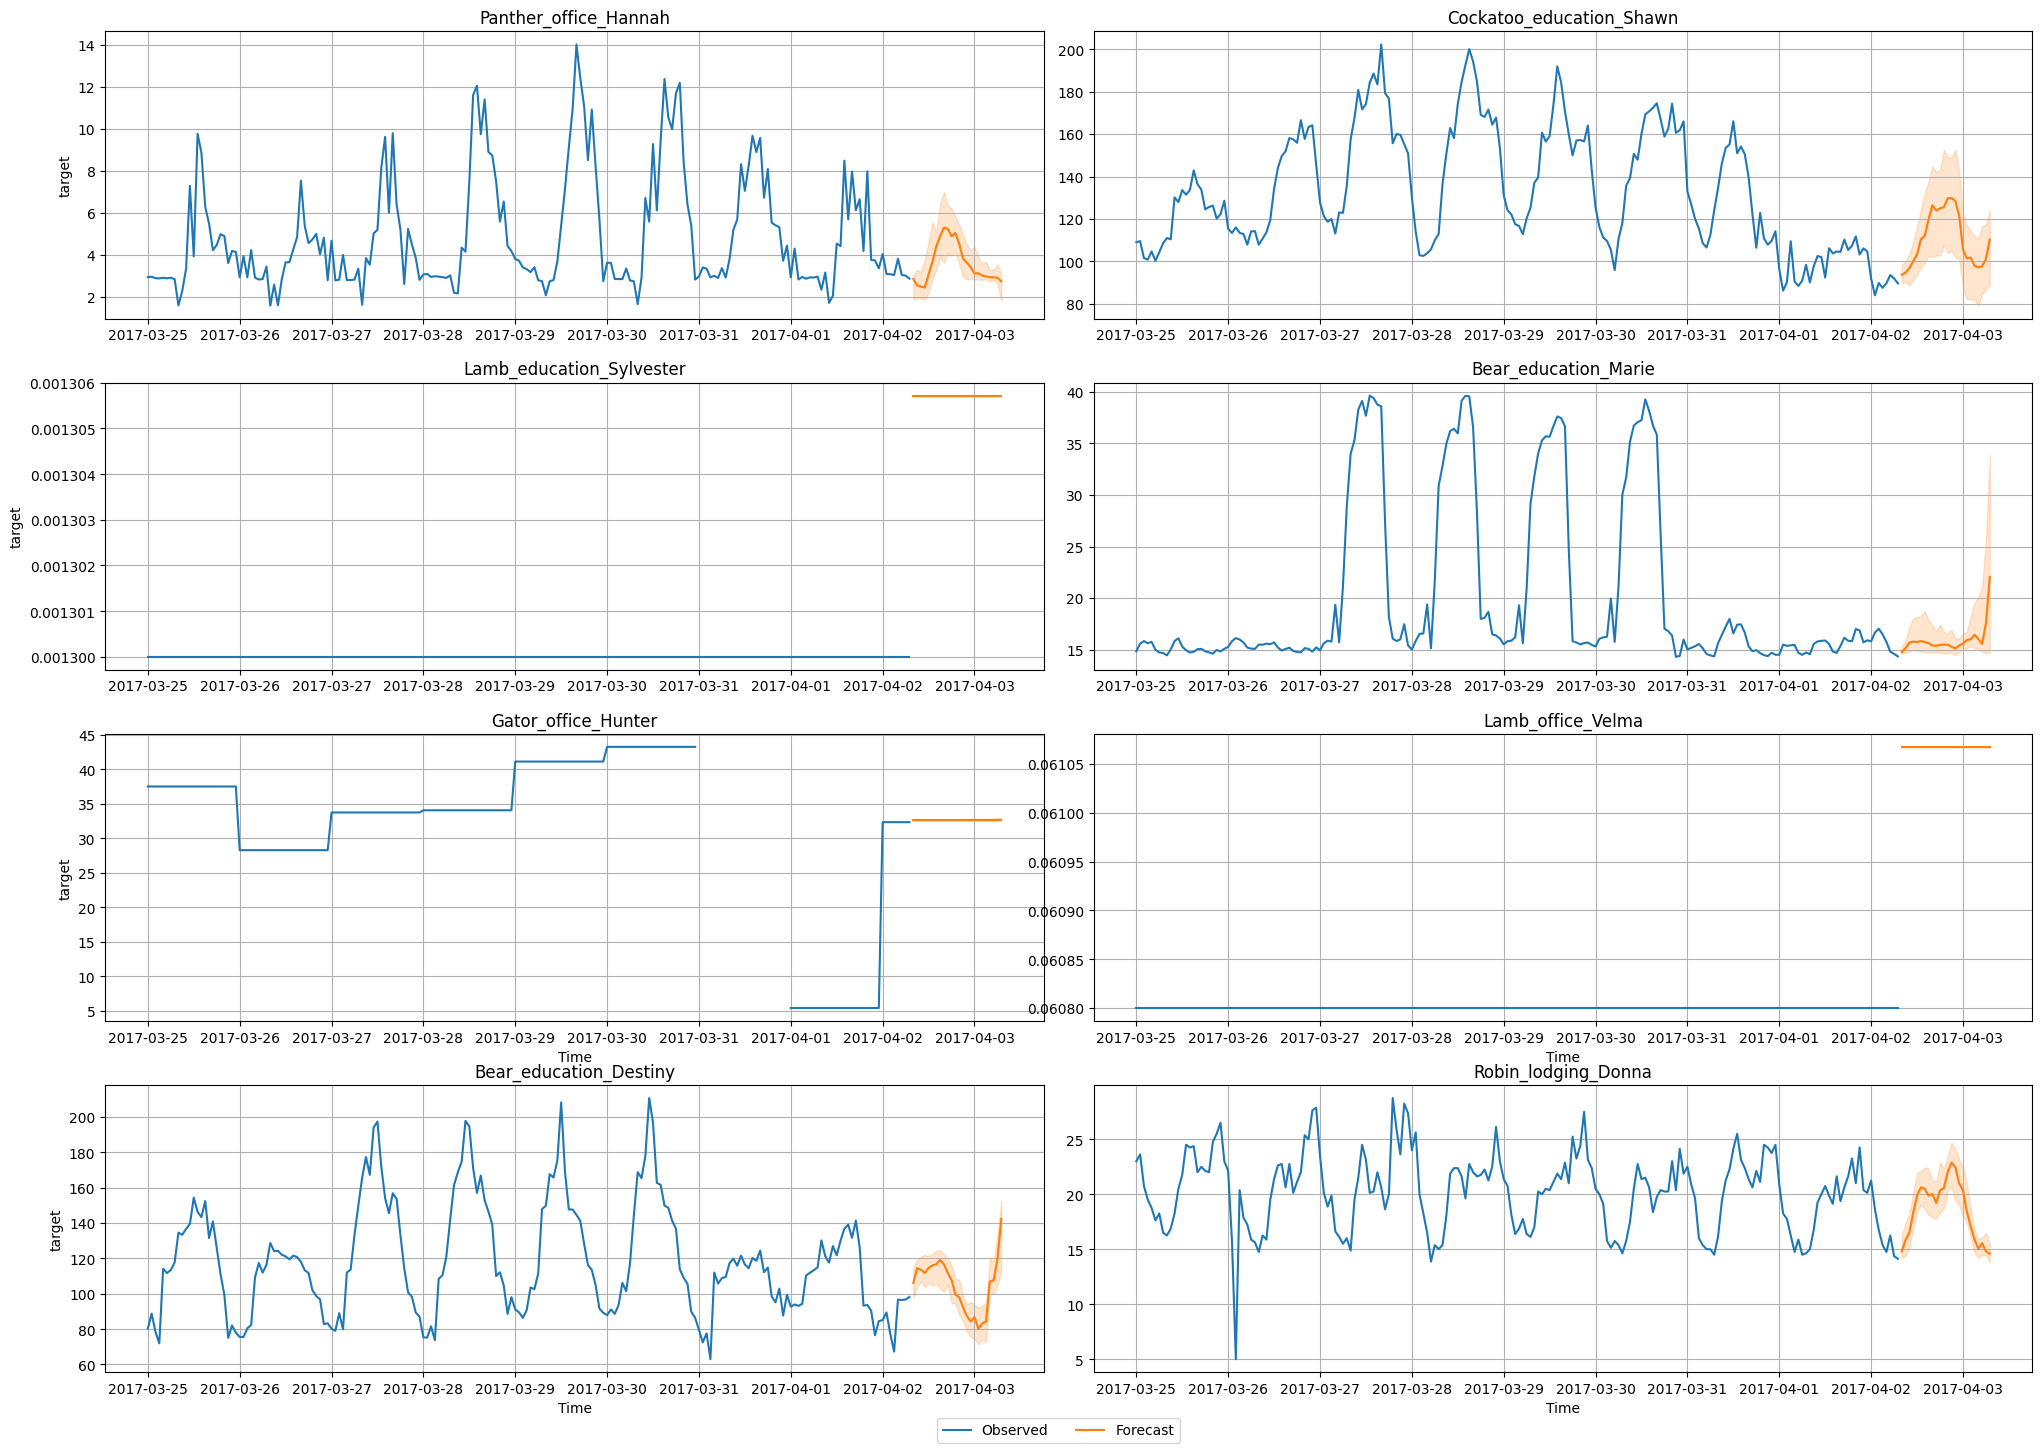

In [66]:
%%time
predictions = predictor.predict(train_data)
predictor.plot(train_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200)

With same test data, benchmark against different different models.

In [69]:
predictor2 = TimeSeriesPredictor(
    prediction_length=prediction_length,
    freq="h",
    path="MWE-chronos-ensemble",
    target="target",
    eval_metric="MASE",
    cache_predictions=False
)

predictor2.fit(
    train_data,
    time_limit=1200,
    presets="high_quality"
#    excluded_model_types=["AutoARIMA"]
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to 'MWE-chronos-ensemble'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #80-Ubuntu SMP Mon May 15 15:18:26 UTC 2023
CPU Count:          192
GPU Count:          0
Memory Avail:       957.90 GB / 1007.56 GB (95.1%)
Disk Space Avail:   779.92 GB / 866.44 GB (90.0%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 1200,
 'verbosity': 2}

Provided train_data has 17309152 rows (NaN fraction=9.7%), 1577 

In [70]:
predictor2.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,DeepAR,-0.758308,-0.904949,14.106510,21.577838,165.403670,9
1,WeightedEnsemble,-0.763304,-0.801805,119.637039,127.153635,9.022204,11
2,SeasonalNaive,-0.851853,-1.304331,3.581806,10.338701,14.409372,1
3,AutoETS,-0.956133,-1.017970,69.967078,69.446867,15.682639,7
4,PatchTST,-0.969415,-0.966716,4.061051,3.911194,141.142490,10
5,DynamicOptimizedTheta,-1.066542,-0.997338,31.483191,32.217736,15.985656,6
6,CrostonSBA,-1.471742,-1.430104,23.871651,15.045722,15.646380,4
7,NPTS,-1.711983,-1.736053,7.724894,7.002624,13.897287,5
8,TemporalFusionTransformer,-4.261110,-2.198033,6.877882,6.845512,165.677029,8
9,RecursiveTabular,-4.946631,-3.531575,8.827006,7.634011,81.457201,2


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


CPU times: user 13min 36s, sys: 15.8 s, total: 13min 52s
Wall time: 1min 37s


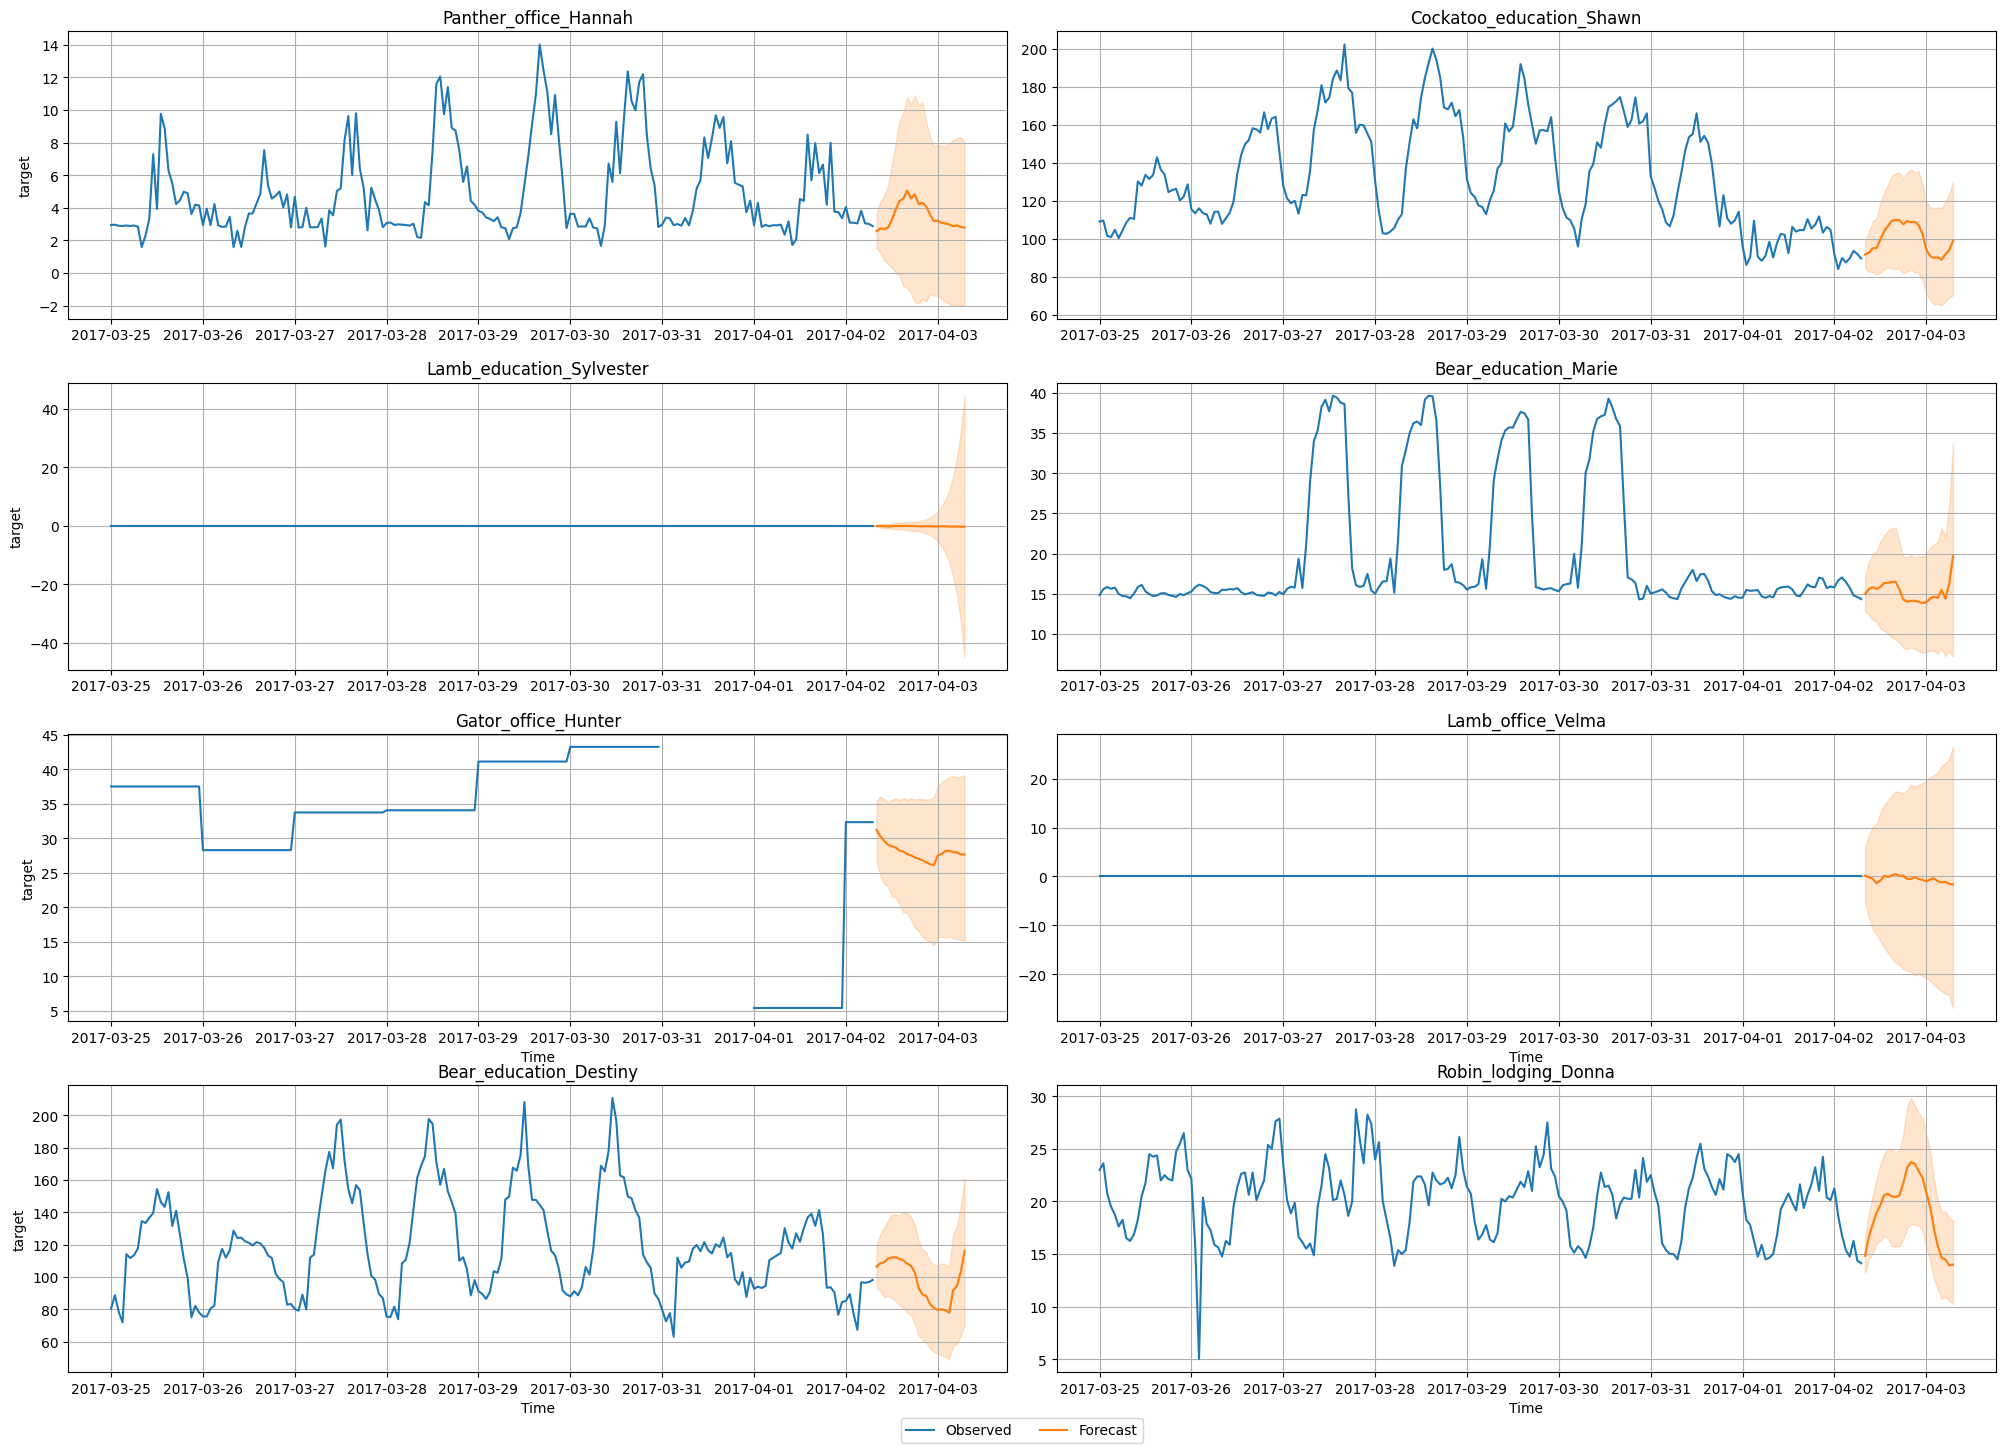

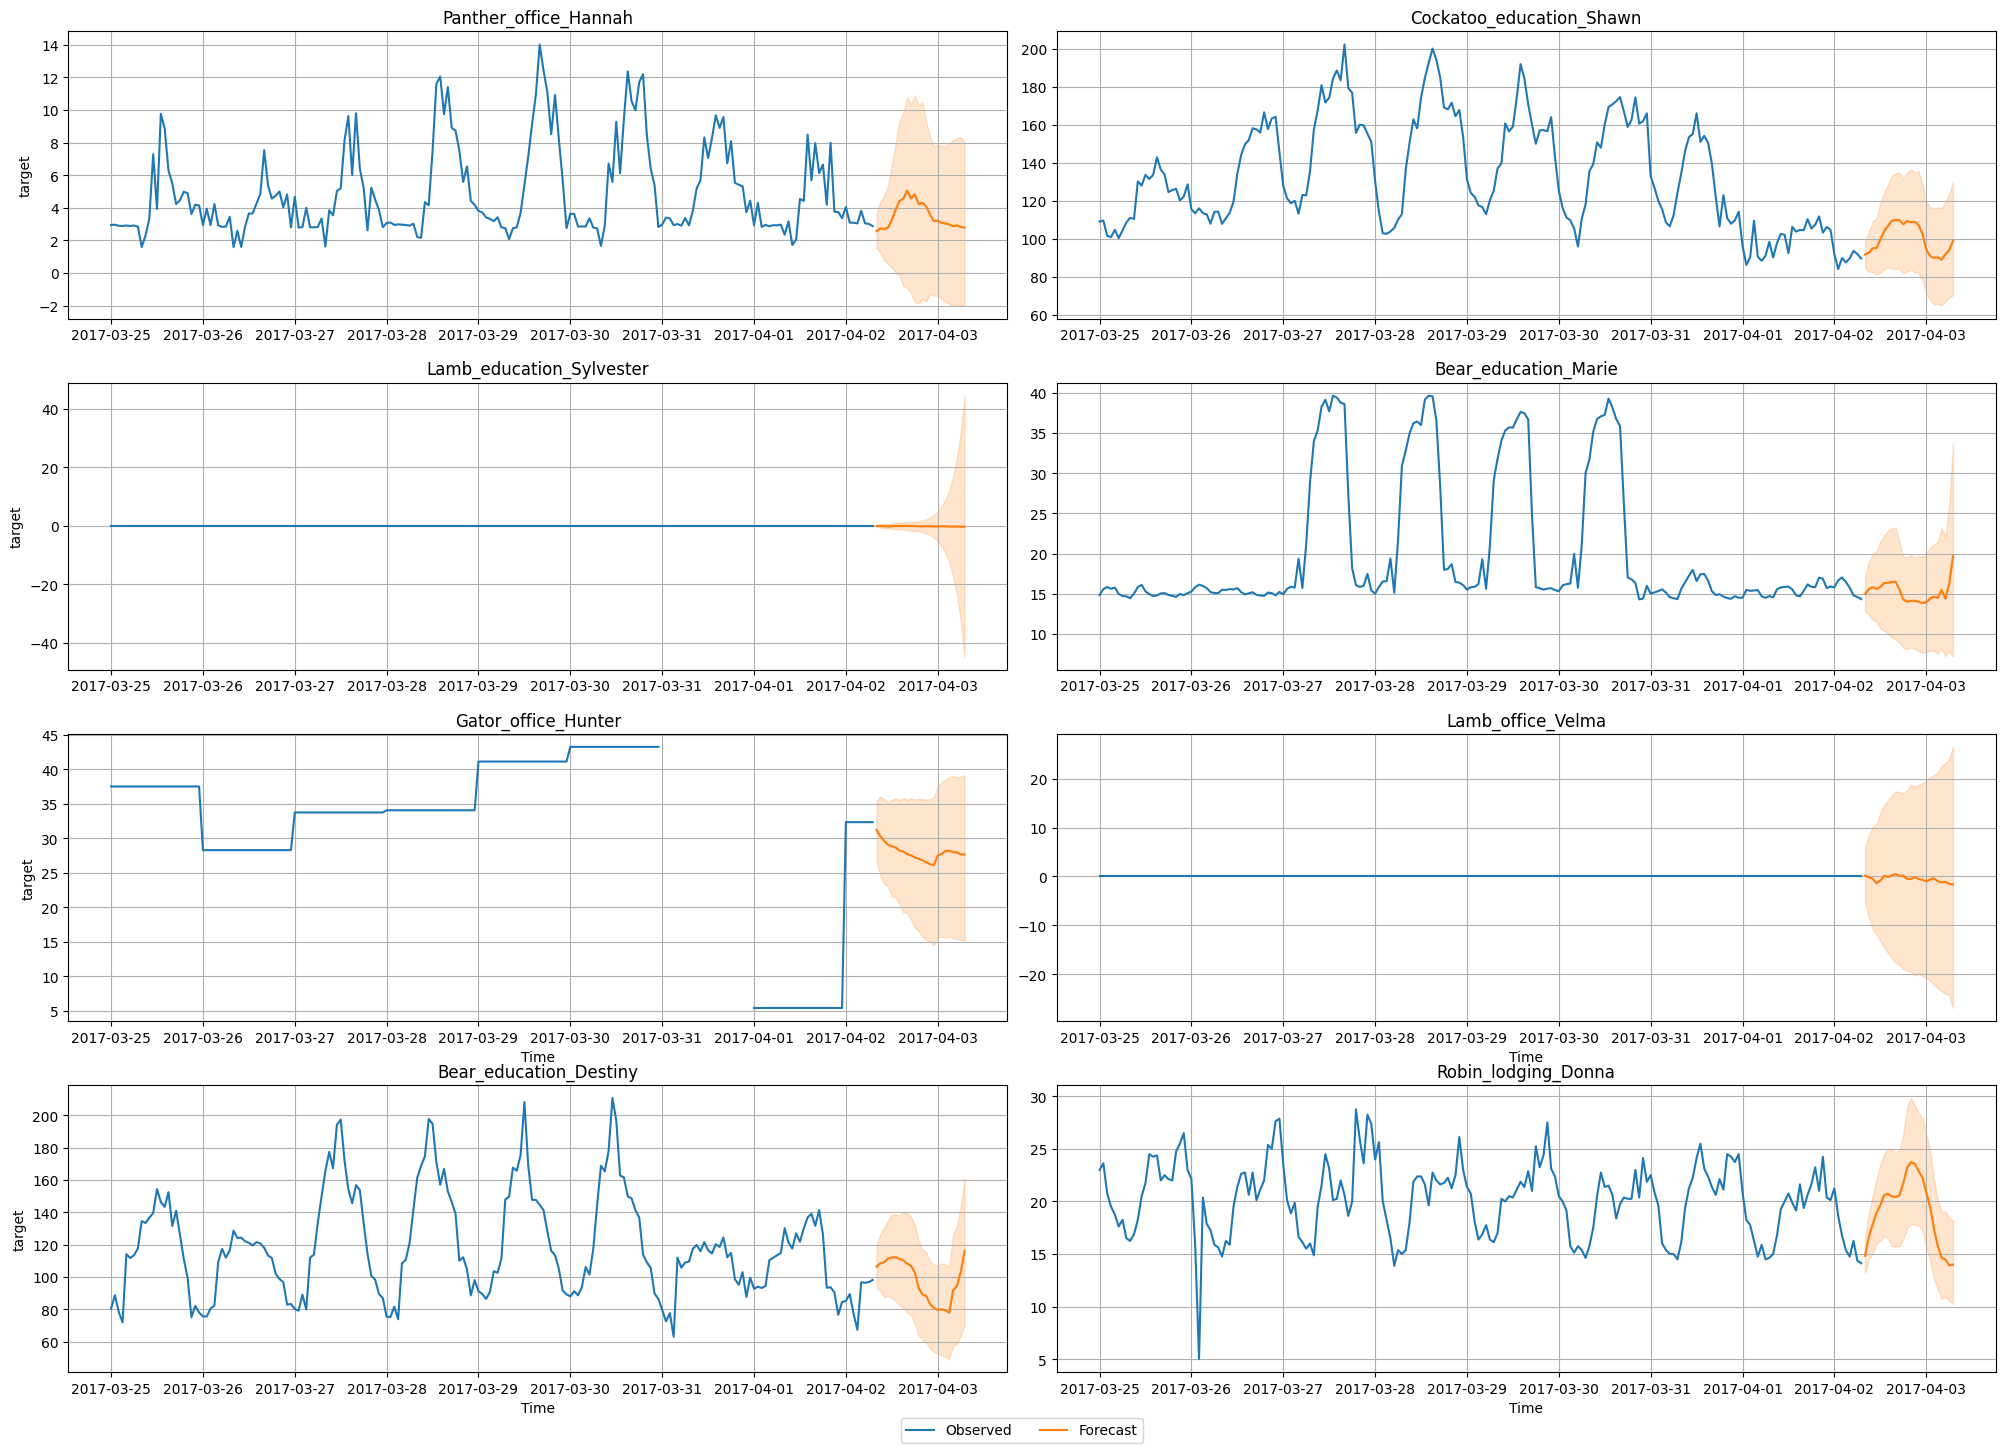

In [71]:
%%time
predictions2 = predictor2.predict(train_data)
predictor2.plot(train_data, predictions2, quantile_levels=[0.1, 0.9], max_history_length=200)

Now, test ensemble of Chronos and leading models from benchmark.

In [72]:
predictor3 = TimeSeriesPredictor(
    prediction_length=prediction_length,
    freq="h",
    path="MWE-chronos-ensemble2",
    target="target",
    eval_metric="MASE",
    cache_predictions=False
)

predictor3.fit(
    train_data,
    time_limit=5000,
    hyperparameters={
    "SeasonalNaive": {},
    "PatchTST": {},
    "DeepARModel": {},
    "RecursiveTabular": {}, 
    "ChronosModel": [
        {"model_path": "amazon/chronos-t5-mini","device": 'xpu',"context_length": 500}
    ],
    }
)

Beginning AutoGluon training... Time limit = 5000s
AutoGluon will save models to 'MWE-chronos-ensemble2'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #80-Ubuntu SMP Mon May 15 15:18:26 UTC 2023
CPU Count:          192
GPU Count:          0
Memory Avail:       927.05 GB / 1007.56 GB (92.0%)
Disk Space Avail:   779.98 GB / 866.44 GB (90.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': {'ChronosModel': [{'context_length': 500,
                                       'device': 'xpu',
                                       'model_path': 'amazon/chronos-t5-mini'}],
                     'DeepARModel': {},
                     'PatchTST': {},
                     'RecursiveTabular': {},
                     'SeasonalNaive': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length'

In [73]:
splitter = ExpandingWindowSplitter(prediction_length=prediction_length, num_val_windows=4)
for window_idx, (train_split, val_split) in enumerate(splitter.split(test_data)):
    score = predictor3.evaluate(val_split)
    print(f"Window {window_idx}: score = {score}")

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


Window 0: score = {'MASE': -0.54971267415243}


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


Window 1: score = {'MASE': -0.7503064096597318}


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


Window 2: score = {'MASE': -0.6306500096279023}


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


Window 3: score = {'MASE': -0.5583180393703262}


In [74]:
%%time
predictions3 = predictor3.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


CPU times: user 15min 5s, sys: 7.34 s, total: 15min 13s
Wall time: 1min 14s


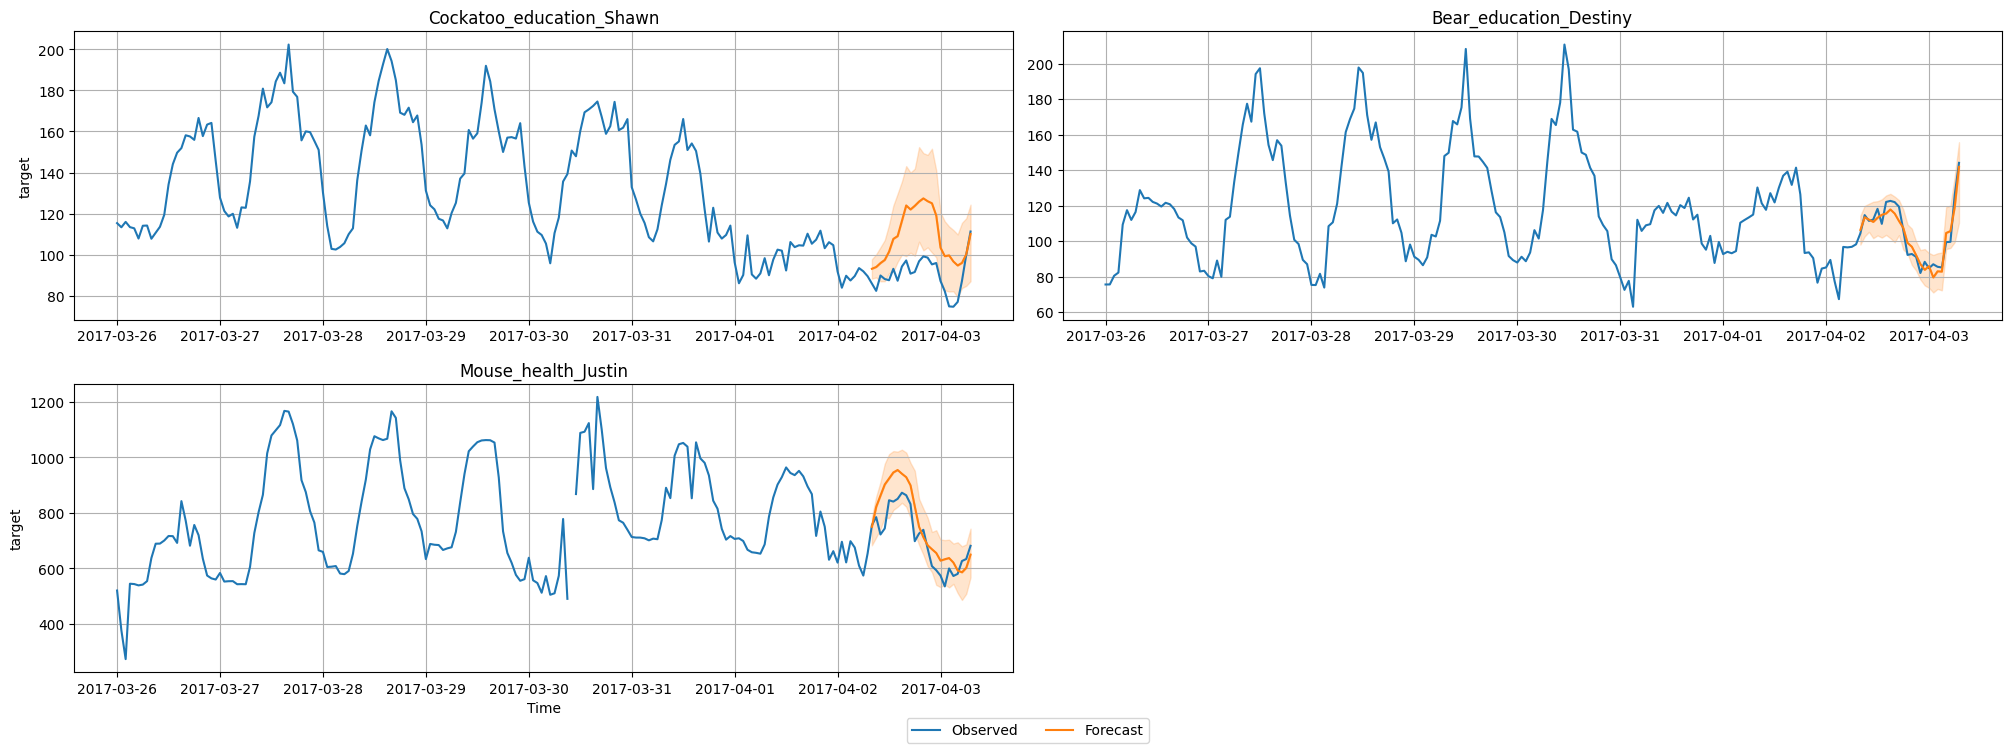

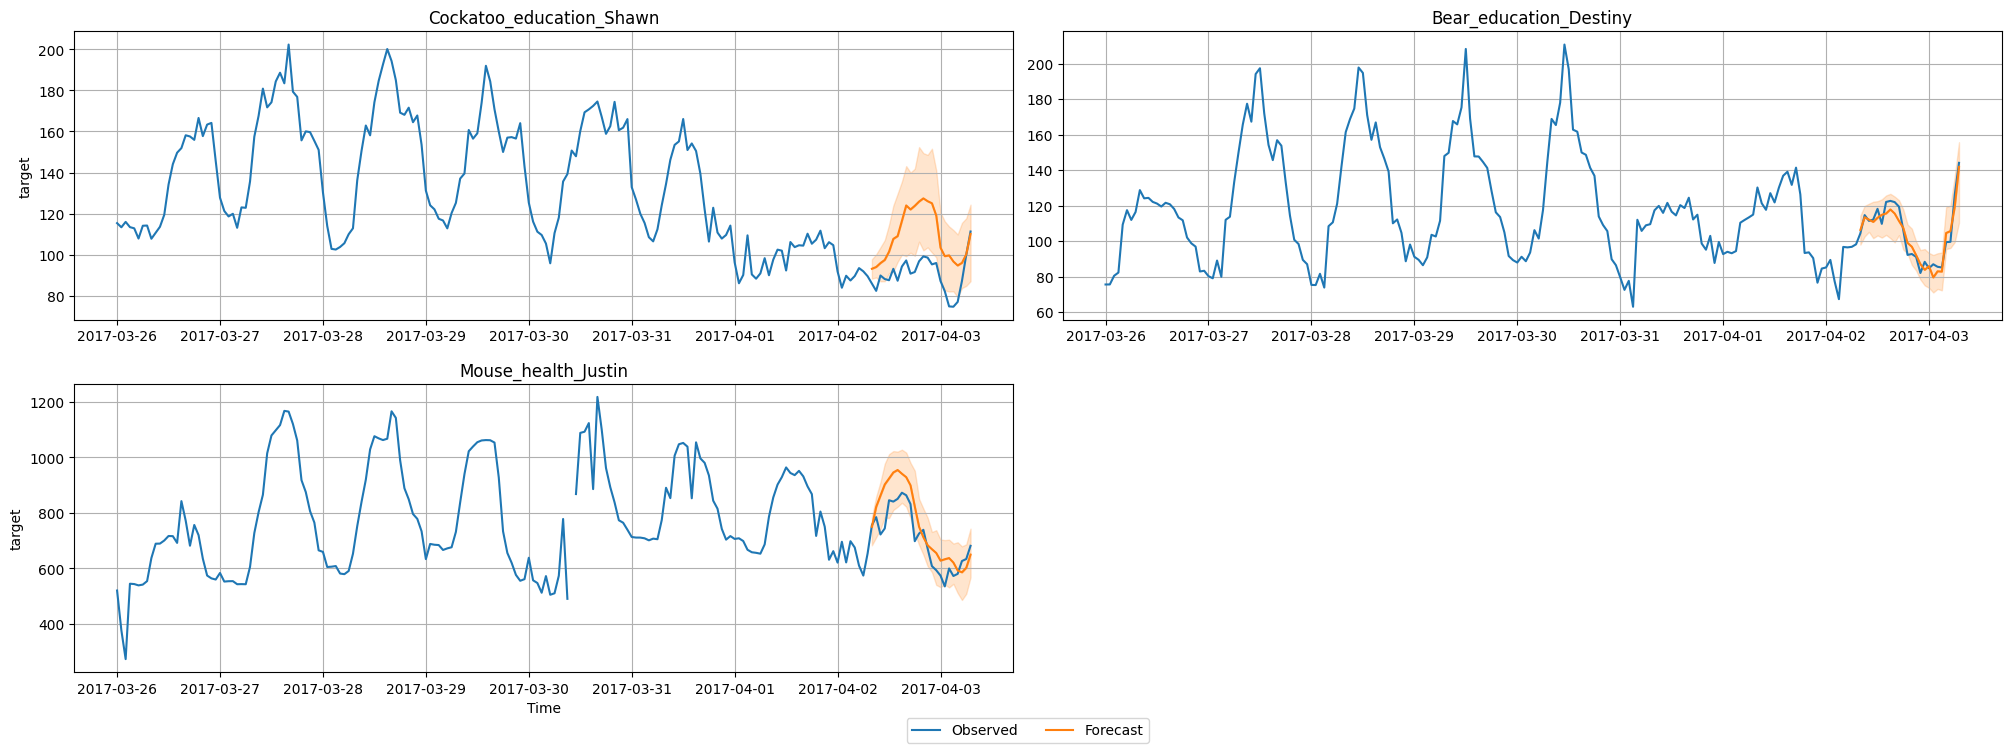

In [78]:
predictor3.plot(
    data=test_data, 
    predictions=predictions3, 
    item_ids=["Cockatoo_education_Shawn", "Bear_education_Destiny","Mouse_health_Justin"],
    max_history_length=200,
)

Zero shot test on Private Data set

In [79]:
df_zs = pd.read_csv("Cemex2.csv")
df_zs["timestamp"] = pd.to_datetime(df_zs["timestamp"],format="%m/%d/%y %H:%M")
zeroshotdata = TimeSeriesDataFrame(df_zs)
zeroshotdata.head()

kwh     kw  DNI  DHI  GHI  Dew Point  \
item_id timestamp                                                    
CEMEX   2021-09-28 00:00:00  32.0  128.0  0.0  0.0  0.0       5.90   
        2021-09-28 00:15:00  32.0  128.0  0.0  0.0  0.0       5.90   
        2021-09-28 00:30:00  32.0  128.0  0.0  0.0  0.0       5.90   
        2021-09-28 00:45:00  32.0  128.0  0.0  0.0  0.0       5.95   
        2021-09-28 01:00:00  32.0  128.0  0.0  0.0  0.0       6.00   

                             Temperature  Pressure  Relative Humidity  \
item_id timestamp                                                       
CEMEX   2021-09-28 00:00:00        24.00     922.0              31.25   
        2021-09-28 00:15:00        23.90     922.0              31.44   
        2021-09-28 00:30:00        23.80     922.0              31.63   
        2021-09-28 00:45:00        23.65     922.0              31.99   
        2021-09-28 01:00:00        23.50     922.0              32.35   

                             Wind Direction  Wind Speed  Surface Albedo  
item_id timestamp                                                        
CEMEX   2021-09-28 00:00:00           258.0         0.1            0.22  
        2021-09-28 00:15:00           226.5         0.1            0.22  
        2021-09-28 00:30:00           195.0         0.1            0.22  
        2021-09-28 00:45:00           163.5         0.1            0.22  
        2021-09-28 01:00:00           132.0         0.1            0.22

In [91]:
cem_pred_length = 96
cem_context_length = 500
window=192
cemex_train, cemex_test = zeroshotdata.train_test_split(prediction_length=cem_pred_length,end_index=cem_context_length+192)
cemex_train.tail()

kwh     kw  DNI  DHI  GHI  Dew Point  \
item_id timestamp                                                    
CEMEX   2021-10-04 21:45:00  32.0  128.0  0.0  0.0  0.0       6.25   
        2021-10-04 22:00:00  32.0  128.0  0.0  0.0  0.0       6.60   
        2021-10-04 22:15:00  32.0  128.0  0.0  0.0  0.0       6.60   
        2021-10-04 22:30:00  64.0  256.0  0.0  0.0  0.0       6.60   
        2021-10-04 22:45:00  64.0  256.0  0.0  0.0  0.0       6.90   

                             Temperature  Pressure  Relative Humidity  \
item_id timestamp                                                       
CEMEX   2021-10-04 21:45:00         21.9     922.0              36.27   
        2021-10-04 22:00:00         21.6     922.0              37.91   
        2021-10-04 22:15:00         21.4     922.0              38.38   
        2021-10-04 22:30:00         21.2     922.0              38.85   
        2021-10-04 22:45:00         21.0     922.0              40.17   

                             Wind Direction  Wind Speed  Surface Albedo  
item_id timestamp                                                        
CEMEX   2021-10-04 21:45:00           216.0        0.70            0.22  
        2021-10-04 22:00:00           218.0        0.70            0.22  
        2021-10-04 22:15:00           219.5        0.65            0.22  
        2021-10-04 22:30:00           221.0        0.60            0.22  
        2021-10-04 22:45:00           223.0        0.55            0.22

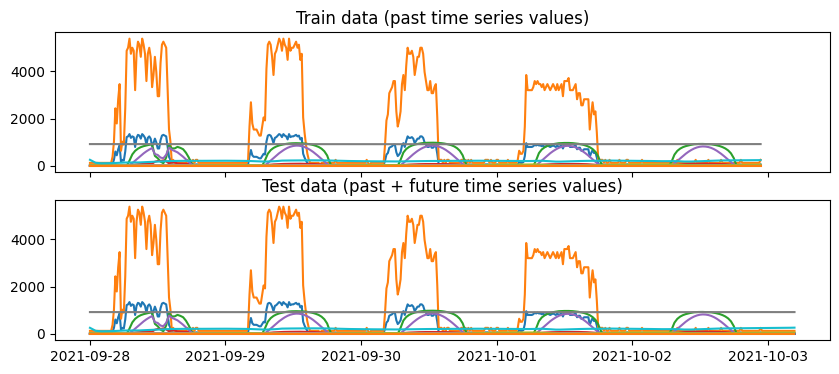

In [81]:
item_id = "CEMEX"
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[10, 4], sharex=True)
train_ts = cemex_train.loc[item_id]
test_ts = cemex_test.loc[item_id]
ax1.set_title("Train data (past time series values)")
ax1.plot(train_ts)
ax2.set_title("Test data (past + future time series values)")
ax2.plot(test_ts)
#for ax in (ax1, ax2):
#    ax.fill_between(np.array([train_ts.index[-1], test_ts.index[-1]]), test_ts.min(), test_ts.max(), color="C1", alpha=0.3, label="Forecast horizon")
#plt.legend()
#plt.show()

Setting predictor from hyperparameters above - mini model and 500 context length

In [101]:
predictor4 = TimeSeriesPredictor(
    prediction_length=cem_pred_length,
    freq="15min",
    path="MWE-zeroshot",
    target="kwh",
    eval_metric="MASE",
)

predictor4.fit(
    cemex_train,
    hyperparameters={
        "Chronos": {
        "model_path": "amazon/chronos-t5-mini",
        "device": 'xpu',
        "context_length": 500
         }
    },
)

Beginning AutoGluon training...
AutoGluon will save models to 'MWE-zeroshot'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #80-Ubuntu SMP Mon May 15 15:18:26 UTC 2023
CPU Count:          192
GPU Count:          0
Memory Avail:       956.42 GB / 1007.56 GB (94.9%)
Disk Space Avail:   779.43 GB / 866.44 GB (90.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': '15min',
 'hyperparameters': {'Chronos': {'context_length': 500,
                                 'device': 'xpu',
                                 'model_path': 'amazon/chronos-t5-mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'kwh',
 'verbosity'

In [102]:
%%time
cemex = predictor4.predict(cemex_train)

Model not specified in predict, will default to the model with the best validation score: Chronos[amazon__chronos-t5-mini]


CPU times: user 14.1 ms, sys: 0 ns, total: 14.1 ms
Wall time: 13.3 ms


In [103]:
predictor4.evaluate(cemex_test)
predictor4.leaderboard(cemex_test)

Model not specified in predict, will default to the model with the best validation score: Chronos[amazon__chronos-t5-mini]
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Chronos[amazon__chronos-t5-mini],-0.229331,-1.629477,0.80659,1.009113,0.004914,1


In [95]:
splitter = ExpandingWindowSplitter(prediction_length=cem_pred_length, num_val_windows=4)
for window_idx, (train_split, val_split) in enumerate(splitter.split(cemex_test)):
    score = predictor4.evaluate(val_split)
    print(f"Window {window_idx}: score = {score}")

Model not specified in predict, will default to the model with the best validation score: Chronos[amazon__chronos-t5-mini]
Model not specified in predict, will default to the model with the best validation score: Chronos[amazon__chronos-t5-mini]


Window 0: score = {'MASE': -1.1787371335268613}


Model not specified in predict, will default to the model with the best validation score: Chronos[amazon__chronos-t5-mini]


Window 1: score = {'MASE': -1.3995752344441381}


Model not specified in predict, will default to the model with the best validation score: Chronos[amazon__chronos-t5-mini]


Window 2: score = {'MASE': -1.7909602779765637}
Window 3: score = {'MASE': -0.2293309274181813}


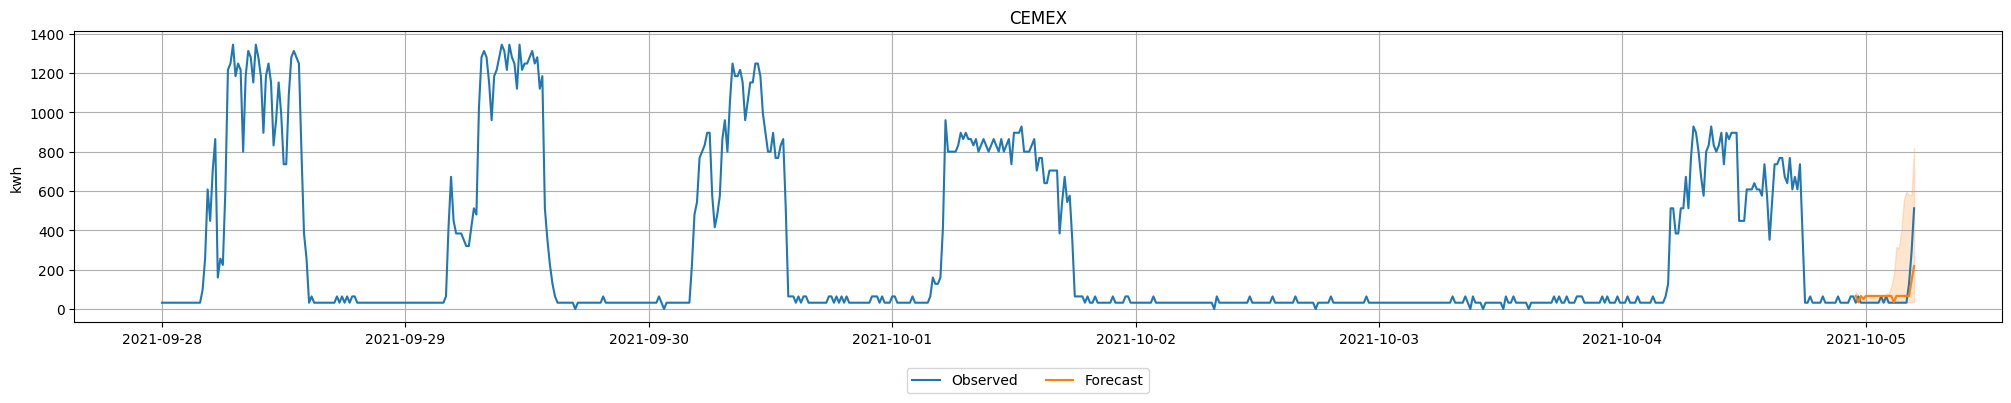

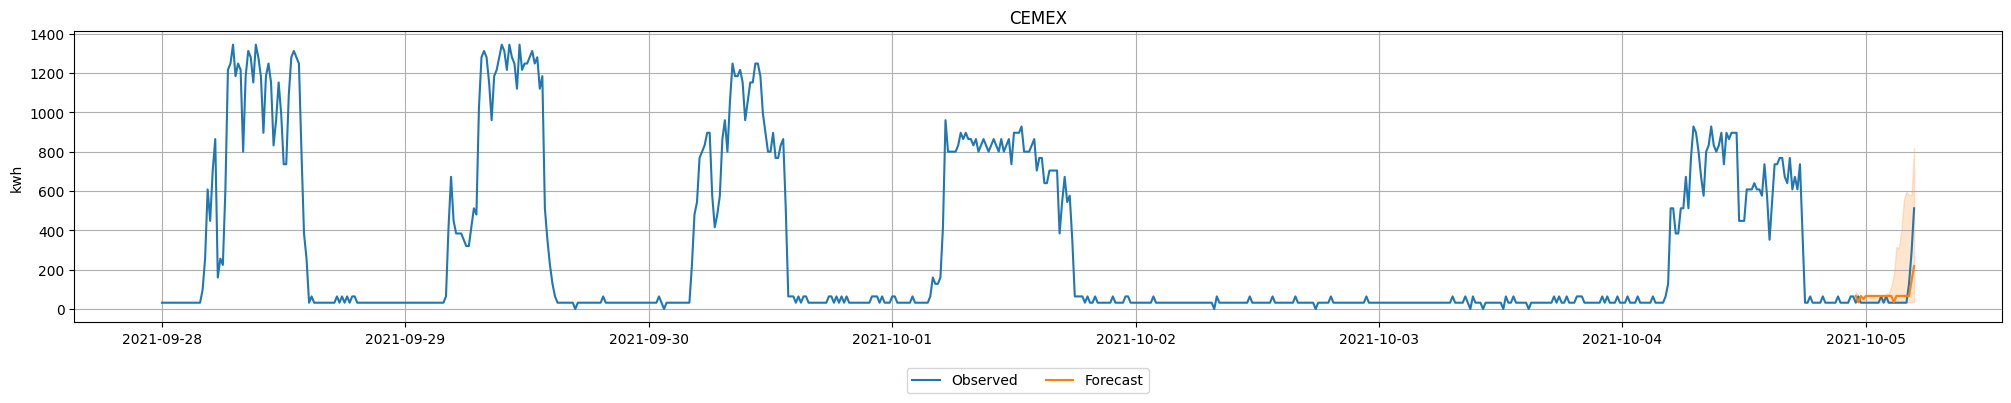

In [104]:
predictor4.plot(
    data=cemex_test, 
    predictions=cemex, 
    item_ids=["CEMEX"],
    max_history_length=25000,
)

Optimizing hyperparameters for DeepAR

In [7]:
predictor5 = TimeSeriesPredictor(
    prediction_length=prediction_length,
    freq="h",
    path="MWE-chronos-ensemble3",
    target="target",
    eval_metric="MASE",
    cache_predictions=False
)

predictor5.fit(
    train_data,
    time_limit=12000,
    hyperparameters={
    "DeepARModel": [
        {"context_length": 3*prediction_length,"num_layers": 2},
        {"context_length": 4*prediction_length,"num_layers": 2},
        {"context_length": 5*prediction_length,"num_layers": 2},
        {"context_length": 3*prediction_length,"num_layers": 2,"max_epochs": 200},
        {"context_length": 3*prediction_length,"num_layers": 3},
        {"context_length": 4*prediction_length,"num_layers": 3},
        {"context_length": 5*prediction_length,"num_layers": 3},
        {"context_length": 3*prediction_length,"num_layers": 2,"max_epochs": 200},
        {"context_length": 3*prediction_length,"num_layers": 4},
        {"context_length": 4*prediction_length,"num_layers": 4},
        {"context_length": 5*prediction_length,"num_layers": 4},
        {"context_length": 3*prediction_length,"num_layers": 2,"max_epochs": 200},
    ],
    "ChronosModel": [
        {"model_path": "amazon/chronos-t5-mini","device": 'xpu',"context_length": 500}
    ],
    }
)

Beginning AutoGluon training... Time limit = 12000s
AutoGluon will save models to 'MWE-chronos-ensemble3'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #80-Ubuntu SMP Mon May 15 15:18:26 UTC 2023
CPU Count:          192
GPU Count:          0
Memory Avail:       989.83 GB / 1007.56 GB (98.2%)
Disk Space Avail:   778.18 GB / 866.44 GB (89.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': {'ChronosModel': [{'context_length': 500,
                                       'device': 'xpu',
                                       'model_path': 'amazon/chronos-t5-mini'}],
                     'DeepARModel': [{'context_length': 72, 'num_layers': 2},
                                     {'context_length': 96, 'num_layers': 2},
                                     {'context_length': 120, 'num_layers': 2},
   

In [8]:
%%time
predictions5 = predictor5.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


CPU times: user 1h 2min 3s, sys: 1min 36s, total: 1h 3min 39s
Wall time: 2min 3s


In [9]:
predictor5.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.542909,-0.615574,119.143513,149.024740,9.806376,14
1,Chronos[amazon__chronos-t5-mini],-0.559125,-0.653915,55.550989,55.654178,9.527272,1
2,DeepAR_8,-0.698296,-0.730446,15.036470,20.638790,387.542603,9
3,DeepAR_12,-0.714368,-0.741214,15.200323,20.625372,405.947497,13
4,DeepAR_10,-0.730773,-0.789713,16.822643,25.405084,506.482371,11
5,DeepAR_11,-0.739321,-0.769112,17.051626,25.798591,613.129013,12
6,DeepAR_6,-0.752186,-0.799420,16.210208,24.322323,436.143283,7
7,DeepAR_3,-0.771981,-0.828726,15.007990,22.847757,339.463782,4
8,DeepAR_5,-0.772012,-0.778885,15.927845,22.594073,238.453307,6
9,DeepAR_7,-0.814670,-0.887875,15.614268,24.800519,427.925694,8


In [ ]:
splitter = ExpandingWindowSplitter(prediction_length=prediction_length, num_val_windows=4)
for window_idx, (train_split, val_split) in enumerate(splitter.split(test_data)):
    score = predictor5.evaluate(val_split)
    print(f"Window {window_idx}: score = {score}")

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
